# Imports

In [1]:
import json
import os
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

from matplotlib import cm as CM
from scipy import io
from scipy.ndimage import gaussian_filter
from sklearn.neighbors import KDTree
from torchinfo import summary
from torchvision.transforms import v2

In [2]:
drive = None
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
from constants import *

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

root = root if drive is None else "/content/drive/MyDrive/crowd-counting"
path = path  #######

In [5]:
MODEL_NAME = "MCNN"

In [8]:
class MCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.column1 = nn.Sequential(
            nn.Conv2d(3, 16, 9, padding=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 7, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 16, 7, padding=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 8, 7, padding=3),
            nn.ReLU(inplace=True),
        )

        self.column2 = nn.Sequential(
            nn.Conv2d(3, 20, 7, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(20, 40, 5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(40, 20, 5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(20, 10, 5, padding=2),
            nn.ReLU(inplace=True),
        )

        self.column3 = nn.Sequential(
            nn.Conv2d(3, 24, 5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(24, 48, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(48, 24, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(24, 12, 3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.fuse = nn.Conv2d(30, 1, 1, padding=0)

        self._initialize_weights()

    def forward(self, img):
        x1 = self.column1(img)
        x2 = self.column2(img)
        x3 = self.column3(img)
        x = torch.cat((x1, x2, x3), 1)
        x = self.fuse(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [9]:
model = MCNN()
summary(model, (8, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
MCNN                                     [8, 1, 56, 56]            --
├─Sequential: 1-1                        [8, 8, 56, 56]            --
│    └─Conv2d: 2-1                       [8, 16, 224, 224]         3,904
│    └─ReLU: 2-2                         [8, 16, 224, 224]         --
│    └─MaxPool2d: 2-3                    [8, 16, 112, 112]         --
│    └─Conv2d: 2-4                       [8, 32, 112, 112]         25,120
│    └─ReLU: 2-5                         [8, 32, 112, 112]         --
│    └─MaxPool2d: 2-6                    [8, 32, 56, 56]           --
│    └─Conv2d: 2-7                       [8, 16, 56, 56]           25,104
│    └─ReLU: 2-8                         [8, 16, 56, 56]           --
│    └─Conv2d: 2-9                       [8, 8, 56, 56]            6,280
│    └─ReLU: 2-10                        [8, 8, 56, 56]            --
├─Sequential: 1-2                        [8, 10, 56, 56]           --
│

In [360]:
class AdaptiveResize:
    def __init__(self, out_shape):
        self.out_shape = out_shape

    def __call__(self, img):
        img = v2.Resize(self.out_shape, antialias=True)(img)
        return img

In [392]:
dmap_transform = v2.Compose(
    [
        lambda x: np.expand_dims(x, -1),  ## add channel dim to dmap
        v2.ToImage(),
        v2.ToDtype(
            torch.float32, scale=True
        ),  ## these two are equivalent to the deprecated v2.ToTensor()
    ]
)

img_transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.ColorJitter(),
        v2.RandomGrayscale(p=0.1),
        lambda x: v2.functional.adjust_gamma(
            x, gamma=torch.FloatTensor(1).uniform_(0.8, 1.2)
        ),
        # lambda x: x/255
    ]
)

### warning: if multiprocessing w/ num_workers > 0, lambda functions may break and custom classes may be needed

In [393]:
class CrowdDataset(torch.utils.data.Dataset):
    """
    CrowdDataset for ShanghaiTech_A.
    Indexing returns _____________________________________________
    ds_scale = ____
    """

    def __init__(self, split, path="ShanghaiTech_A", ds_scale=4):

        assert split in ["train", "test"], "`split` must be either `train` or `test`."
        self.data_path = f"{path}/{split}_data"
        self.ds_scale = ds_scale

    def __getitem__(self, index):

        try:
            gt_dmap = np.load(f"{self.data_path}/gt_maps/GT_IMG_{index+1}.npy")
            img = plt.imread(
                f"{self.data_path}/images/IMG_{index+1}.jpg"
            ).copy()  # copy for writability
            if len(img.shape) == 2:
                img = np.repeat(
                    img[:, :, np.newaxis], 3, axis=-1
                )  ## convert B&W to RGB via repeat
        except FileNotFoundError as e:
            raise Exception("File not found. Index may be out of bounds.") from e

        out_shape = (img.shape[0] // self.ds_scale, img.shape[1] // self.ds_scale)

        gt_dmap = dmap_transform(gt_dmap)
        gt_dmap = AdaptiveResize(out_shape)(gt_dmap)
        gt_dmap *= self.ds_scale ** 2  ## re-normalize values after resizing
        img = img_transform(img)

        return img, gt_dmap

    def __len__(self):
        return len(os.listdir(f"{self.data_path}/images"))

In [394]:
train_data = CrowdDataset(split="train")
test_data = CrowdDataset(split="test")

## Dataloaders

### Note we use batch size of 1! This is because PyTorch Dataloaders require identically sized images.
To circumvent this, there are a number of methods, such as writing a custom collate function. We will perform **gradient accumulation** over `BATCH_SIZE` steps in our training function later.

In [395]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

In [396]:
# for img, gt in train_loader:
#     break

## Train

In [397]:
def train(model, train_loader, val_loader, optimizer, criterion, device):

    model.train()
    model.to(device)
    train_losses, val_losses = [], []
    val_accuracies = []

    for epoch in range(EPOCHS):

        print(f"Epoch {epoch+1}/{EPOCHS}")

        for step, (img, gt) in enumerate(train_loader):

            out = model(img)
            loss = criterion(out, gt)
            loss /= BATCH_SIZE
            train_losses.append(loss.item())  # every step
            loss.backward()

            ########### NOTE: fix later, consider when last batch is not of size BATCH_SIZE!!
            if (step + 1) % BATCH_SIZE == 0 or (step + 1) == len(train_loader):

                # # monitor overall gradient norm
                # grads = [
                #     param.grad.detach().flatten()
                #     for param in model.parameters()
                #     if param.grad is not None
                # ]
                # norm = torch.cat(grads).norm()

                optimizer.step()
                optimizer.zero_grad()

            if (step + 1) % (BATCH_SIZE * PRINT_ITERS) == 0 and step != 0:

                mae = abs(out.sum() - gt.sum())
                print(
                    f"Step: {step+1}/{len(train_loader)} | Loss: {loss.item():.2e} |",
                    f"Pred: {out.sum():.3f} | True: {gt.sum():.3f} |",
                    f"MAE: {mae:.3f}",
                )

                # val_loss, val_acc = eval(model, val_loader, criterion, device)
                # val_losses.append(val_loss)
                # val_accuracies.append(val_acc)
                # print(
                #     f"Step: {step}/{len(train_loader)}, Running Average Loss: {np.mean(train_losses):.3f} |",
                #     f"Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.3f} | Grad Norm: {norm:.2f}",
                # )
                # model.train()

        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            },
            f"{path}/checkpoints/{MODEL_NAME}_EPOCH_{epoch+1}_SEED_{SEED}.pt",
        )

        with open(
            f"{path}/train_logs/{MODEL_NAME}_SEED_{SEED}_train_losses.json", "w"
        ) as f:
            json.dump(train_losses, f)

        # with open(
        #     f"{path}/train_logs/{MODEL_NAME}_SEED_{SEED}_val_losses.json", "w"
        # ) as f2:
        #     json.dump(val_losses, f2)

        # with open(
        #     f"{path}/train_logs/{MODEL_NAME}_SEED_{SEED}_val_accuracies.json", "w"
        # ) as f3:
        #     json.dump(val_accuracies, f3)

        # torch.save(deltas, f"{path}/train_logs/{MODEL_NAME}_SEED_{SEED}_deltas.pt")

    # return train_losses, val_losses, val_accuracies
    return train_losses

In [398]:
model = MCNN()
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion = nn.MSELoss()

## Driver code

In [399]:
## Driver code
train_losses = train(model, train_loader, test_loader, optimizer, criterion, device)
# train_losses, val_losses, val_accuracies = train(
#     model, train_loader, test_loader, optimizer, criterion, device
# )

Epoch 1/2
Step: 32/300 | Loss: 6.43e-05 | Pred: 877.520 | True: 643.451 | MAE: 234.069
Step: 64/300 | Loss: 2.05e-05 | Pred: 281.498 | True: 198.334 | MAE: 83.164
Step: 96/300 | Loss: 3.56e-04 | Pred: 1038.525 | True: 748.471 | MAE: 290.054
Step: 128/300 | Loss: 4.57e-05 | Pred: 559.158 | True: 424.336 | MAE: 134.822
Step: 160/300 | Loss: 1.11e-03 | Pred: 1820.400 | True: 1351.095 | MAE: 469.305
Step: 192/300 | Loss: 2.38e-05 | Pred: 298.117 | True: 292.995 | MAE: 5.123
Step: 224/300 | Loss: 3.45e-04 | Pred: 392.241 | True: 973.861 | MAE: 581.621
Step: 256/300 | Loss: 2.39e-04 | Pred: 507.568 | True: 459.992 | MAE: 47.576
Step: 288/300 | Loss: 4.00e-05 | Pred: 1407.974 | True: 946.730 | MAE: 461.245
Epoch 2/2
Step: 32/300 | Loss: 1.20e-05 | Pred: 548.172 | True: 158.533 | MAE: 389.638
Step: 64/300 | Loss: 1.25e-04 | Pred: 1201.175 | True: 1194.429 | MAE: 6.746
Step: 96/300 | Loss: 2.03e-05 | Pred: 255.951 | True: 198.334 | MAE: 57.617
Step: 128/300 | Loss: 3.72e-04 | Pred: 1082.075 | T

## todo: eval function on val and test

#### temporary informal inference

In [423]:
test_idx = 64
gt_dmap = np.load(f"{data_path}/test_data/gt_maps/GT_IMG_{test_idx+1}.npy")
img = plt.imread(f"{data_path}/test_data/images/IMG_{test_idx+1}.jpg").copy()
if len(img.shape) == 2:
    img = np.repeat(img[:, :, np.newaxis], 3, axis=-1)
out_shape = (img.shape[0] // 4, img.shape[1] // 4)

gt_dmap = dmap_transform(gt_dmap)
gt_dmap = AdaptiveResize(out_shape)(gt_dmap)
gt_dmap *= 4 ** 2  ## re-normalize values after resizing
img = img_transform(img)

In [428]:
model.eval()
with torch.no_grad():
    out = model(img.unsqueeze(0)).squeeze(0)

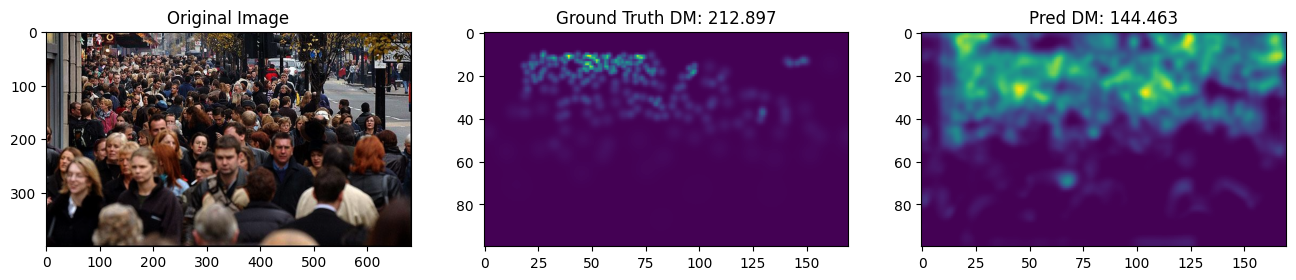

In [434]:
fig, ax = plt.subplots(1, 3, figsize=(16, 12))
ax[0].imshow(img.permute(1, 2, 0))
ax[0].set_title("Original Image")
ax[1].imshow(gt_dmap.permute(1, 2, 0))
ax[1].set_title(f"Ground Truth DM: {gt_dmap.sum():.3f}")
ax[2].imshow(out.permute(1, 2, 0))
ax[2].set_title(f"Pred DM: {out.sum():.3f}")
plt.show()